# Market Signal Analysis

This notebook loads the processed data from `signals.parquet` and visualizes the aggregated market sentiment and trading signals over time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load Processed Data

Load the data from the Parquet file. If the file doesn't exist, an error will be shown. Make sure you have run `python main.py` first.

In [2]:
try:
    df = pd.read_parquet('../data/signals.parquet')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    print("Data loaded successfully!")
    print(f"Dataset contains {len(df)} tweets.")
    df.head()
except FileNotFoundError:
    print("Error: `signals.parquet` not found. Please run the main pipeline script first (`python main.py`).")

Data loaded successfully!
Dataset contains 10 tweets.


## 2. Memory-Efficient Visualization: Aggregating Signals Over Time

Plotting thousands of individual data points is inefficient and hard to read. Instead, we **aggregate** the data into time-based bins (e.g., hourly) and plot the mean signal and the volume of tweets. This is a memory-efficient and effective way to visualize large time-series datasets.

In [3]:
if 'df' in locals():
    # Aggregate data by hour
    # 'resample' is a powerful pandas method for time-series frequency conversion
    hourly_agg = df.resample('H').agg(
        composite_signal_mean=('composite_signal', 'mean'),
        sentiment_score_mean=('sentiment_score', 'mean'),
        tweet_volume=('id', 'count')
    )

    # Remove hours with no data
    hourly_agg.dropna(subset=['composite_signal_mean'], inplace=True)

    print("Aggregated hourly data:")
    print(hourly_agg.head())

Aggregated hourly data:
                           composite_signal_mean  sentiment_score_mean  \
timestamp                                                                
2025-08-03 01:00:00+00:00               0.021053                   0.0   
2025-08-03 02:00:00+00:00               0.000000                   0.0   
2025-08-03 03:00:00+00:00               0.000000                   0.0   
2025-08-03 06:00:00+00:00               0.400000                   0.0   
2025-08-03 07:00:00+00:00              -0.600000                  -1.0   

                           tweet_volume  
timestamp                                
2025-08-03 01:00:00+00:00             1  
2025-08-03 02:00:00+00:00             1  
2025-08-03 03:00:00+00:00             1  
2025-08-03 06:00:00+00:00             1  
2025-08-03 07:00:00+00:00             1  


C:\Users\ykswo\AppData\Local\Temp\ipykernel_30016\1098471637.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_agg = df.resample('H').agg(


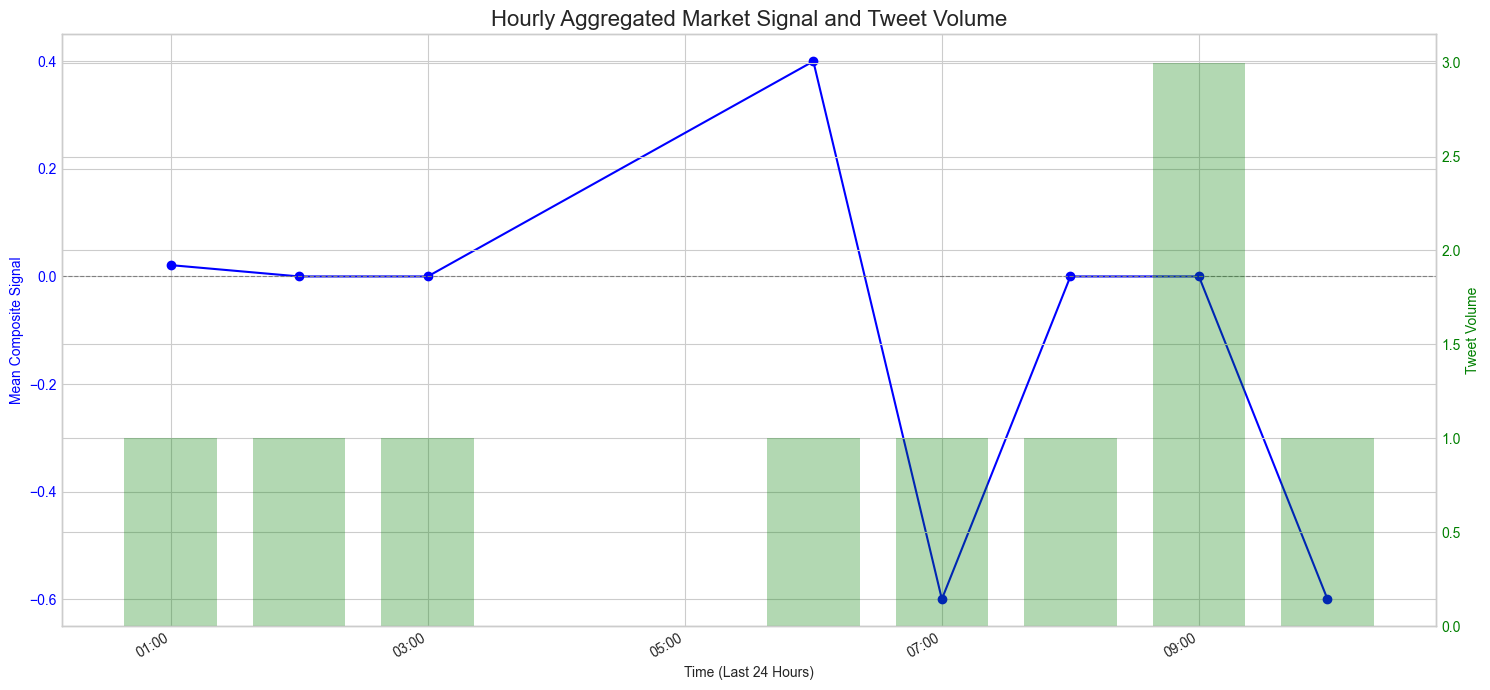

In [4]:
if 'hourly_agg' in locals() and not hourly_agg.empty:
    fig, ax1 = plt.subplots(figsize=(15, 7))
    
    # Plot 1: Mean Composite Signal
    ax1.set_title('Hourly Aggregated Market Signal and Tweet Volume', fontsize=16)
    ax1.set_xlabel('Time (Last 24 Hours)')
    ax1.set_ylabel('Mean Composite Signal', color='blue')
    ax1.plot(hourly_agg.index, hourly_agg['composite_signal_mean'], color='blue', marker='o', linestyle='-', label='Mean Composite Signal')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    
    # Create a second y-axis for tweet volume
    ax2 = ax1.twinx()
    ax2.set_ylabel('Tweet Volume', color='green')
    ax2.bar(hourly_agg.index, hourly_agg['tweet_volume'], color='green', alpha=0.3, width=0.03, label='Tweet Volume')
    ax2.tick_params(axis='y', labelcolor='green')

    # Formatting the x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    fig.autofmt_xdate()
    
    fig.tight_layout()
    plt.show()

### Interpretation

- **Blue Line (Mean Composite Signal)**: Represents the overall market mood. Values above zero suggest a more bullish sentiment/engagement, while values below zero suggest bearishness.
- **Green Bars (Tweet Volume)**: Shows the volume of discussion. A high signal value combined with high volume can be a strong indicator (high confidence).